In [365]:
import time
import numpy as np
from scipy import signal

import matplotlib.pyplot as plt
import matplotlib.animation as animation

import constants 
import beamformer_fir

from importlib import reload
# force a reload of the constants
reload(constants)
reload(beamformer_fir)


<module 'beamformer' from 'c:\\Users\\Josh\\Documents\\projects\\sound-compass\\src\\prototype\\beamformer.py'>

In [366]:
class AudioSource:
    """Generates a single stream of audio from a certain angle"""

    frequency: float
    level: float
    direction_deg: float

    _phase: float = 0
    def __init__(self, frequency: float, level: float, direction_deg: float) -> None:
        self.frequency = frequency
        self.level = level
        self.direction_deg = direction_deg
        pass

    def GetAudio(self, numberOfSamples: int) -> np.ndarray:
        t = (np.arange(numberOfSamples) + self._phase) / constants.sample_rate  # time vector
        tx = self.level * np.exp(-2j * np.pi * self.frequency * t)
        self._phase += numberOfSamples
        return tx
        pass

    pass


class MicSignalGenerator:
    """Generates a set of mic signals from a set of audio sources"""

    audioSources: list[AudioSource]
    _beamformer:beamformer_fir.BeamFormer
    microphone_positions: list[dict[str, float]]
    buffer_size = 1024

    def __init__(self, audioSources: list[AudioSource], beamformer:beamformer_fir.BeamFormer):
        self.audioSources = audioSources
        self._beamformer = beamformer

        self._calculateArrayGeometry()
        pass

    def _calculateArrayGeometry(self):
        # Define the array geometry
        self.microphone_positions_outer = np.array(
            [
                {
                    "x": constants.ARRAY_RADIUS
                    * np.cos(2 * np.pi * i_outer / constants.NUM_MICS_outer),
                    "y": constants.ARRAY_RADIUS
                    * np.sin(2 * np.pi * i_outer / constants.NUM_MICS_outer),
                }
                for i_outer in range(constants.NUM_MICS_outer)
            ]
        )
        self.microphone_positions_inner = np.array(
            [
                {
                    "x": constants.ARRAY_RADIUS_inner
                    * np.cos(2 * np.pi * i / constants.NUM_MICS_inner),
                    "y": constants.ARRAY_RADIUS_inner
                    * np.sin(2 * np.pi * i / constants.NUM_MICS_inner),
                }
                for i in range(constants.NUM_MICS_inner)
            ]
        )

        self.microphone_positions = np.concatenate(
            (self.microphone_positions_outer, self.microphone_positions_inner)
        )
        self.microphone_positions = np.insert(self.microphone_positions, 0, {"x":0.0, "y":0.0})

        pass

    def calculate_steering_vector(self, direction_deg: float, freq:float=10) -> np.ndarray:
        """Calculate the steering vector for a given direction and frequency

        Args:
            direction_deg (float): Steering direction
            freq (float): frequency of interest

        Returns:
            np.ndarray: a complex steering vector
        """

        direction_rad = direction_deg / 180 * np.pi  # convert to radians

        x = np.array([mic["x"] for mic in self.microphone_positions]) * .628 * freq /constants.c
        y = np.array([mic["y"] for mic in self.microphone_positions]) * .628 * freq /constants.c

        steering_vector = np.exp(
            # -2j * np.pi * (x * np.cos(direction_rad) + y * np.sin(direction_rad))

            # https://pysdr.org/content/doa.html#circular-arrays
            -2j * np.pi * (x * np.cos(direction_rad) + y * np.sin(direction_rad))
        )
        steering_vector = steering_vector.reshape(-1, 1)  # Nrx1
        print(steering_vector)

        return steering_vector
        pass

    def _filter_audio(self, mic_signal:np.ndarray, filter :beamformer_fir.MicrophoneBeamFilter ) -> np.ndarray:

        print(filter._numerators)
        print(filter._denominators)
        print(filter._filter_state)
        print(mic_signal.squeeze().shape)
        filtered_signal, z = signal.lfilter(filter._numerators, filter._denominators, mic_signal, zi=filter._filter_state)
        filter._filter_state = z
        return filtered_signal

        pass
    def GenerateSignals(self, freq:float):

        mic_signals :np.ndarray = np.zeros((constants.NUM_MICS, self.buffer_size), 'complex128' )
        source_signals :np.ndarray = np.zeros((constants.NUM_MICS, self.buffer_size), 'complex128' )
        for a in self.audioSources:
            source_signal = a.GetAudio(self.buffer_size)
            source_signal = source_signal.reshape(1,-1)
            
            # steering_vector = self.calculate_steering_vector(a.direction_deg, freq)
            # source_signals = steering_vector @ source_signal # Simulate the received signal X through a matrix multiply
            for mic in range(constants.NUM_MICS):
                filtered_sig = self._filter_audio(source_signal, self._beamformer.get_mic_generation_filter(mic, a.direction_deg))
                source_signals[mic] = filtered_sig

            mic_signals += source_signals
            # print(mic_signals.shape)
            pass

        return mic_signals
    
    pass


In [367]:
sources = [
    AudioSource(1000, 1.0, 0), 
    # AudioSource(1000,0.15, 20)
    ]
_beamformer = beamformer_fir.BeamFormer()
generator = MicSignalGenerator(sources, _beamformer)
_beamformer.update_mic_positions(generator.microphone_positions)

# generates 16 channels of audio
mic_signals = generator.GenerateSignals(1000)
print(mic_signals.squeeze().shape)

t = (np.arange(generator.buffer_size) ) / constants.sample_rate  # time vector
plot_samples = 150
print(generator.microphone_positions[0])
plt.plot(t[:plot_samples] , np.asarray(mic_signals[0,:]).squeeze().real[0:plot_samples]) # the asarray and squeeze are just annoyances we have to do because we came from a matrix
print(generator.microphone_positions[1])
plt.plot(t[:plot_samples] , np.asarray(mic_signals[1,:]).squeeze().real[0:plot_samples])
# print(generator.microphone_positions[2])
# plt.plot(t[:plot_samples] , np.asarray(mic_signals [2,:]).squeeze().real[0:plot_samples])
# print(generator.microphone_positions[3])
# plt.plot(t[:plot_samples] , np.asarray(mic_signals [3,:]).squeeze().real[0:plot_samples])
plt.show()

{'x': 0.0, 'y': 0.0}
[ 0.25  1.    4.   25.  ]
[  1.  25. 100. 100.  25.]
[-0.12948207  1.88346614  9.93525896 -3.01294821]
(1024,)


ValueError: object of too small depth for desired array

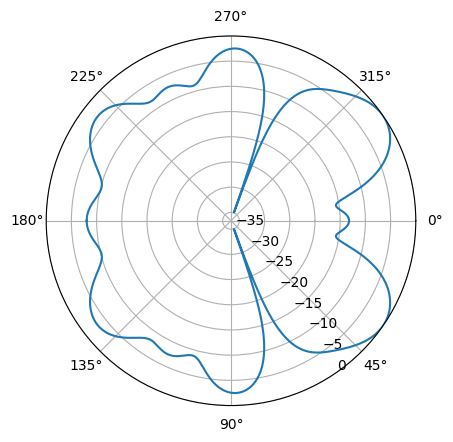

In [ ]:
theta_scan = np.linspace(-1*np.pi, np.pi, 1024) # 1024 different thetas between -180 and +180 degrees
results = []
Nr = constants.NUM_MICS
d = 0.2

for theta_i in theta_scan:
   # w = np.exp(-2j * np.pi * d * np.arange(Nr) * np.sin(theta_i)) # Conventional, aka delay-and-sum, beamformer
   w = _beamformer.calculate_steering_vector(theta_i * 180 /np.pi)
   X_weighted = w.conj().T @ mic_signals # apply our weights. remember X is 3x10000
   results.append(10*np.log10(np.var(X_weighted))) # power in signal, in dB so its easier to see small and large lobes at the same time
results -= np.max(results) # normalize (optional)

fig, ax = plt.subplots(subplot_kw={'projection': 'polar'})
ax.plot(theta_scan, results) # MAKE SURE TO USE RADIAN FOR POLAR
ax.set_theta_zero_location('E') # make 0 degrees point up
ax.set_theta_direction(-1) # increase clockwise
ax.set_rlabel_position(55)  # Move grid labels away from other labels
plt.show()